# Numerical Optimization and Large Scale Linear Algebra - Assignment 2B
## Ilias Katsampalos

Disclaimer:
The methods implemented below are built in such a way so that they can scale well and solve similar systems for which the convergence criteria for `A` are met. I am aware that, if I followed a more data-oriented design for the particular problem, I would be able to optimize the memory consumption, although, a more general solution was preferred in this case. 

In [1]:
import numpy as np
from scipy.linalg import norm, solve, block_diag
import time
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(palette='deep', color_codes=True, font_scale=1.3)

### Table Creation

In [2]:
n = 32
T = np.zeros((n**2, n**2))

diag_ind = np.diag_indices(n**2)
T[diag_ind] = 4
lo_diag_ind_rows, lo_diag_ind_columns = np.diag_indices(n**2 - 1)
lo_diag_ind_rows = lo_diag_ind_rows + 1
T[lo_diag_ind_rows, lo_diag_ind_columns] = -1

up_diag_ind_rows, up_diag_ind_columns = np.diag_indices(n**2 - 1)
up_diag_ind_columns = up_diag_ind_columns + 1
T[up_diag_ind_rows, up_diag_ind_columns] = -1

#lower identity
for i in range(n, n**2, n):
    T[i:i+n, i-n:i] = -1 * np.identity(n)

#upper identity
for i in range(0, n**2 -n, n):
    T[i:i+n, i+n:i+2*n] = -1 * np.identity(n)

b = np.ones(n ** 2)

## 1. Implemeneting the iterative methods

### Point Jacobi

For the point jacobi method the iterative scheme is quite trivial and can be implemented in parallel with vectorized operations.
We know that $$Dx^{k+1} = (L+U)x^k + b$$
Since D is a diagonal table, we do not need to find the inverse using elmination. In fact, we calculate $$D^{-1} = [\frac{1}{a_{11}}, \frac{1}{a_{22}},..., \frac{1}{a_{nn}}]$$

where $D^{-1}$ is a vector containing the inverse of the diagonal elements of A. Then, we can rewrite the previous expressions as:
$$x^{k+1} = ((L+U)x^k + b) * {D}^{-1}$$
where $D^{-1} = [\frac{1}{a_{11}}, \frac{1}{a_{22}},..., \frac{1}{a_{nn}}]$ and $((L+U)x^k + b) * {D}^{-1} $ performs an element wise multiplication.

In [3]:
def jacobi(A, b, precision = 10**-6, max_iter = 2000, verbose=False, return_iter  = False):
    start_time = time.time()
    
    #initialize x
    x = np.random.uniform(size=len(A))
    iter_counter = 0
    
    #break the table as A = D - (LU)
    #D is the diagonal and LU = - (L + U)
    D = np.diag(A)
    LU = np.diagflat(D) - A
    
    error = np.finfo('double').max
    
    #calculate x_next while error is big enough or max iteration have not been reached
    while error > precision and iter_counter <= max_iter:
        x_next = (b + (LU @ x)) / D
        iter_counter += 1
        error = norm(x_next - x) / norm(x)
        x = x_next
    
    end_time = time.time()
    if verbose:
        print(f'# found solutions {x}')
        print(f'# in {iter_counter-1} iterations in {end_time - start_time} seconds')
        print(f'# absolute relative error {error}')
    
    if return_iter:
        return x, iter_counter-1
    return x

### Parallel Block Jacobi

The block jacobi method involves the split of the table A in blocks and then the solution of small systems, 2x2, 4x4, 8x8. We have the epxression:
$$D_{block}x^{k+1}_{block} = (L_{block}+U_{block})x^k_{block} + b_{block}$$

In more detail, with a block size 2x2 it is written as:

$$
  \begin{bmatrix}
    a_{11} & a_{12} & & & & & \\
    a_{21} & a_{22} & & & & &\\
    & & a_{33} & a_{34} & & &\\
    & & a_{43} & a_{44} & & &\\
    & & & & \ddots& &\\
    & & & & & &\\
    & & & & &  a_{n-1, n-1} &  a_{n-1, n}\\
    & & & & & a_{n, n-1} & a_{n, n}\\
  \end{bmatrix} 
  \begin{bmatrix}
      x_1^{k+1}\\ 
      x_2^{k+1}\\
      x_3^{k+1}\\
      x_4^{k+1}\\
      \\
      \vdots\\
      x_{n_1}^{k+1}\\
      x_n^{k+1}\\
      \end{bmatrix}
  = 
  \begin{bmatrix}
    0& 0& -a_{13} & -a_{14} & \ldots & -a_{1n-1}&-a_{1n} \\
    0& 0& -a_{23} &-a_{24} & \ldots & -a_{2n-1}&-a_{2n} \\
    -a_{31}& -a_{32}& & & & &\\
    -a_{41}&-a_{42} & & & & &\\
    \vdots& \vdots& & & \ddots& &\\
    \vdots& \vdots& & &\ddots& & &\\
    -a_{n-1,1}& -a_{n-1,2}& & & & 0&0\\
    -a_{n1}&-a_{n,2} & & & & 0&0\\
  \end{bmatrix} 
    \begin{bmatrix}
      x_1^{k}\\ 
      x_2^{k}\\
      x_3^{k}\\
      x_4^{k}\\
      \\
      \vdots\\
      x_{n_1}^{k}\\
      x_n^{k}\\
      \end{bmatrix}
    + 
    \begin{bmatrix}
      b_1^{k}\\ 
      b_2^{k}\\
      b_3^{k}\\
      b_4^{k}\\
      \\
      \vdots\\
      b_{n_1}^{k}\\
      b_n^{k}\\
      \end{bmatrix}
  $$

Executing the operations on the right hand side of the system we have:

$$
  \begin{bmatrix}
    a_{11} & a_{12} & & & & & \\
    a_{21} & a_{22} & & & & &\\
    & & a_{33} & a_{34} & & &\\
    & & a_{43} & a_{44} & & &\\
    & & & & \ddots& &\\
    & & & & & &\\
    & & & & &  a_{n-1, n-1} &  a_{n-1, n}\\
    & & & & & a_{n, n-1} & a_{n, n}\\
  \end{bmatrix} 
  \begin{bmatrix}
      x_1^{k+1}\\ 
      x_2^{k+1}\\
      x_3^{k+1}\\
      x_4^{k+1}\\
      \\
      \vdots\\
      x_{n_1}^{k+1}\\
      x_n^{k+1}\\
      \end{bmatrix}
  = 
    \begin{bmatrix}
      \hat{b_1}^{k}\\ 
      \hat{b_2}^{k}\\
      \hat{b_3}^{k}\\
      \hat{b_4}^{k}\\
      \\
      \vdots\\
      \hat{b_{n_1}}^{k}\\
      \hat{b_n^{k}}\\
      \end{bmatrix}
  $$

In our example we have a block size of 2x2 so for each iteration of the jacobi we have to solve the block systems of the form:

$$
  \begin{bmatrix}
    a_{ii} & a_{ii+1}\\
    a_{i+1i} & a_{i+1i+1}\\
  \end{bmatrix} 
  \begin{bmatrix}
      x_i^{k+1}\\ 
      x_i+1^{k+1}\\
      \end{bmatrix}
  = 
    \begin{bmatrix}
      \hat{b_i}^{k}\\ 
      \hat{b_{i+1}}^{k}\\
      \end{bmatrix}
  $$
  
In the function below the block systems are solved in parallel. In order to do this, the matrix has been reshaped to 3-dimensional table `D_blocked`, with dimensions (p, block size, block size) where p = n/block size. Then by acceessing the elements `D_blocked[:, i, i]` we access the pivot elements of all the blocks simultaneously. Since we have the pivot elements, we  proceed in implementing Gauss Jordan elimination is parallel for all the blocks.

In [4]:
def parallel_block_jacobi(A, b, block_size=2, precision=10 ** -6, max_iter=300, verbose=False, return_iter  = False):
    start_time = time.time()
    iter_counter = 0
    error = np.finfo('double').max
    #dimension of the block table
    p = A.shape[0] // block_size
    n = len(A)
    
    #Calculate the block diagonal table
    A_blocked = A.reshape(p, block_size, p, block_size).swapaxes(1, 2)
    D_blocked = np.diagonal(A_blocked, axis1=0, axis2=1).T
    
    #calculate the LU table as Block Diagonal of A - A
    LU = block_diag(*D_blocked) - A
    
    #initialize the vector x
    x = np.random.uniform(size=n)
    
    #start the block jacobi iteration
    while error > precision and iter_counter <= max_iter:
        #initialize x^{k+1}
        x_next = np.zeros(shape=(p, block_size))
        
        #A hat is the block diagonal shape (p, block size, block size)
        A_hat = D_blocked.copy()
        
        #calculate the bhat and reshape to (p, block size)
        b_hat = LU @ x + b
        b_hat = b_hat.reshape(p, block_size)

        #start parallel gaussian elimination
        for i in range(block_size-1):
            #access all the  pivot elements
            pivot = A_hat[:, i, i]
            
            #eliminate all rows below the pivot
            for j in range(i+1, block_size):
                factor = A_hat[:, j, i] / pivot
                A_hat[:, j, :] -= np.multiply(A_hat[:, i, :].T, factor).T
                b_hat[:, j] -= b_hat[:, i] * factor
        
        #start backwards substitution
        x_next[:, block_size-1] = b_hat[:, block_size-1] / A_hat[:,block_size-1, block_size-1] #element wise division
        for k in range(block_size-2, -1, -1):
            #np.einsum('ij,ij->i',...,...) dot product within the blocks
            x_next[:, k] = (b_hat[:, k] - np.einsum('ij,ij->i', A_hat[:, k, k+1:], x_next[:, k+1:])) \
                           / A_hat[:, k, k] #element wise division
        
        #reshape x_next to original
        x_next = x_next.reshape(n)
        #calculate the error
        error = norm(x_next - x) / norm(x)
        x = x_next.copy()
        iter_counter += 1

    end_time = time.time()
    if verbose:
        print(f'# found solutions {x}')
        print(f'# in {iter_counter - 1} iterations in {end_time - start_time} seconds')
        print(f'# absolute relative error {error}')
    
    if return_iter:
        return x, iter_counter-1
    return x

### Gauss - Seidel

The Gauss-Seidel method is slightly different from the Jacobi method. Here the system that we are asked to solve is:
$$(D-L)x^{k+1} = Ux^k + b$$

where D-L is a lower triangular table. As a result the system can be solved with forward substitution.

In [5]:
def gauss_seidel(A, b, precision=10 ** -6, max_iter=1000, verbose=False, return_iter  = False):
    start_time = time.time()
    n = len(A)
    x = np.random.uniform(size=n)
    iter_counter = 0
    error = np.finfo('double').max
    
    #extract the DL and U tables
    DL = np.tril(A)
    U = - np.triu(A, 1)

    while error > precision and iter_counter <= max_iter:
        #calculate the \hat{b}
        b_hat = U @ x + b
        #initialize the vector x^{k+1}
        x_next = np.zeros(n)
        #start forward substitution
        for i in range(n):
            x_next[i] = (b_hat[i] - DL[i, :i] @ x_next[:i]) / DL[i, i]
        #calculate the error
        error = norm(x_next - x) / norm(x)
        x = x_next.copy()
        iter_counter += 1
    
    end_time = time.time()
    if verbose:
        print(f'# found solutions {x}')
        print(f'# in {iter_counter-1} iterations in {end_time - start_time} seconds')
        print(f'# absolute relative error {error}')
    
    if return_iter:
        return x, iter_counter-1
    return x

### Block Gauss Seidel

This method has similar mentality with the block jacobi method. The matrix `A` and the vectors `x` and `b` are split into blocks. We perform a forward substitution but for each iteration, a smaller system needs to be solved. Here, we cannot avoid the iterative nature of the problem thus we cannot proceed in solving the systems in parallel, since for each block $[x_i, x_{i+1}]$ the previous block of x $[x_{i-1}, x_{i-2}]$ must have been already calculated.

For solving the block systems I used the `solve` method from scipy. An interesting implementation of the gaussian elimination for solving multiple systems in parallel was implemented in the block Jacobi method.

In [6]:
def block_gauss_seidel(A, b, block_size=2, precision=10 ** -6, max_iter=300, verbose=False, return_iter  = False):
    start_time = time.time()
    iter_counter = 0
    error = np.finfo('double').max
    p = A.shape[0] // block_size
    n = len(A)
    
    #construct the upper triangular matrix
    U = -A.copy()
    for i in range(0,n,block_size):
        U[i:i+block_size, :i+block_size] = 0
    x = np.random.uniform(size=n)
    x_next = np.zeros(n)
    
    #start iteration
    while error > precision and iter_counter <= max_iter:
        #calculate the right-hand side
        b_hat = U @ x + b
        x_next = np.zeros(n)
        
        #start forward substitution
        x_next[0:block_size] = solve(A[:block_size, :block_size], b_hat[:block_size])
        for i in range(1, p):
            block_range = slice(i * block_size, (i + 1) * block_size)
            #get the diagonal block
            diag_block = A[block_range, block_range].copy()
            #calculate b tilted 
            b_tilted = b_hat[block_range] - A[block_range, :i * block_size] @ x_next[:i * block_size]
            #elimination for the values of x. the solve methods from scipy is used.
            x_next[block_range] = solve(diag_block, b_tilted)

        error = norm(x_next - x) / norm(x)
        x = x_next.copy()
        iter_counter += 1
    
    end_time = time.time()
    if verbose:
        print(f'# found solutions {x}')
        print(f'# in {iter_counter-1} iterations in {end_time - start_time} seconds')
        print(f'# absolute relative error {error}')
    
    if return_iter:
        return x, iter_counter-1
    return x

Here is a sample execution of the four methods.

In [7]:
res = jacobi(T, b, verbose=True, max_iter=10**4, precision=10**-4)

# found solutions [2.02635687 3.5528831  4.77733584 ... 4.77733596 3.55288307 2.02635692]
# in 843 iterations in 0.6442492008209229 seconds
# absolute relative error 9.97734295123096e-05


In [9]:
res = parallel_block_jacobi(T, b, 2, max_iter=10**4, precision=10**-4, verbose=True)

# found solutions [2.03066048 3.56136042 4.79002043 ... 4.7900206  3.56136027 2.03066041]
# in 679 iterations in 0.5953564643859863 seconds
# absolute relative error 9.961856847576137e-05


In [8]:
res = gauss_seidel(T, b, verbose=True, max_iter=10**4, precision=10**-4)

# found solutions [2.03366929 3.56752027 4.79927794 ... 4.80610627 3.57226638 2.03613319]
# in 497 iterations in 2.1089560985565186 seconds
# absolute relative error 9.941894758124211e-05


In [10]:
res = block_gauss_seidel(T, b, 2, verbose=True, max_iter=10**4, precision=10**-4)

# found solutions [2.03616319 3.57234921 4.80648989 ... 4.81170176 3.57601408 2.03799839]
# in 396 iterations in 18.001813173294067 seconds
# absolute relative error 9.996463288159439e-05


Something that we can observe is that the number of iterations of the Jacobi methods, either point or block are almost double than the number of Gauss Seidel iterations. This is a confirmation of the corrolary `3.4` from "Numerical Linear Algebra" (Dougalis, Noutsos, Hatzidimos), where 

## 2. Performance Comparison
In order to compare the performance of the iterative methods, we will perform 3 runs of each and extract an average, in order to have a stable result in case of fluctuations. Additionally, we will execute the functions with the same amount of required precision in order to compare them on an equal basis.

In [11]:
import pandas as pd
def comparison_diagnostics(solver, name, *args):
    runtime = []
    errors = []
    runs = 3
    for i in range(runs):
        start_time = time.time()
        res = solver(*args)
        end_time = time.time()
        runtime.append(end_time - start_time)
        b_hat = T @ res
        error = norm(b - b_hat) / norm(b)
        errors.append(error)
    df = pd.DataFrame({'runtime':runtime, 'error':error})
    df['solver'] = name
    return df

In [12]:
point_jacobi = comparison_diagnostics(jacobi, 'point_jacobi', T, b, 10**(-5), 10**6)

In [13]:
parallel_jacobi_2_block = comparison_diagnostics(parallel_block_jacobi, 'block_jacobi_2_block', T, b, 2, 10**(-5), 10**6)
parallel_jacobi_4_block = comparison_diagnostics(parallel_block_jacobi, 'block_jacobi_4_block', T, b, 4, 10**(-5), 10**6)
parallel_jacobi_8_block = comparison_diagnostics(parallel_block_jacobi, 'block_jacobi_8_block', T, b, 8, 10**(-5), 10**6)

In [14]:
point_gauss_seidel = comparison_diagnostics(gauss_seidel, 'point_gauss_seidel', T, b, 10**(-5), 10**6)

In [15]:
gauss_seidel_2_block = comparison_diagnostics(block_gauss_seidel, 'block_gauss_seidel_2_block', T, b, 2, 10**(-5), 10**6)
gauss_seidel_4_block = comparison_diagnostics(block_gauss_seidel, 'block_gauss_seidel_4_block', T, b, 4, 10**(-5), 10**6)
gauss_seidel_8_block = comparison_diagnostics(block_gauss_seidel, 'block_gauss_seidel_8_block', T, b, 8, 10**(-5), 10**6)

In [18]:
comparisons = pd.concat([
    point_jacobi
    ,parallel_jacobi_2_block
    ,parallel_jacobi_4_block
    ,parallel_jacobi_8_block
    ,point_gauss_seidel
    ,gauss_seidel_2_block
    ,gauss_seidel_4_block
    ,gauss_seidel_8_block
])

agg = comparisons.groupby('solver').agg(avg_runtime = ('runtime', np.mean), error = ('error', np.mean)).reset_index()
agg.sort_values(by='avg_runtime', ascending=False, inplace=True)
agg

,solver,avg_runtime,error
0,block_gauss_seidel_2_block,25.959003,0.000728
1,block_gauss_seidel_4_block,13.450999,0.000603
2,block_gauss_seidel_8_block,5.700494,0.000539
6,point_gauss_seidel,3.108982,0.000915
5,block_jacobi_8_block,1.278969,0.001054
4,block_jacobi_4_block,0.891457,0.001173
7,point_jacobi,0.879260,0.001831
3,block_jacobi_2_block,0.852677,0.001373


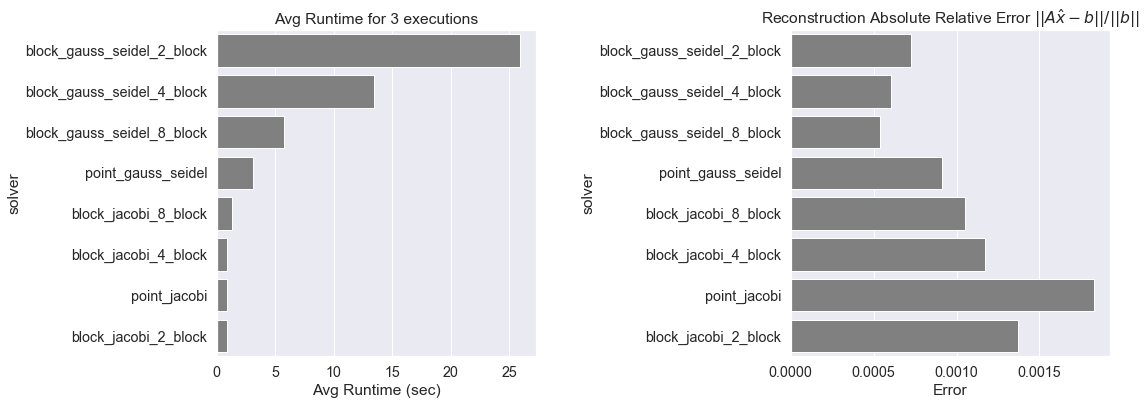

In [21]:
fig, axs = plt.subplots(1,2, figsize=(16,6))
fig.subplots_adjust(wspace=0.8)


sns.barplot('avg_runtime', 'solver', data=agg, color='grey', ax=axs[0])
axs[0].set_xlabel('Avg Runtime (sec)')
axs[0].title.set_text('Avg Runtime for 3 executions')

sns.barplot('error', 'solver', data=agg, color='grey', ax=axs[1])
axs[1].set_xlabel('Error')
axs[1].title.set_text('Reconstruction Absolute Relative Error $||A\hat{x} - b|| / ||b\||$')
plt.show()

Looking at the runtime results we can observe the following:

* The fastest methods are the point Jacobi as well as the block jacobi with ~0.8 seconds
* The slowest method is the block gauss seidel where the block size is 2x2
* Jacobi methods seem to have a faster runtime, although the relative erros when recalculating b are larger than those of the Gauss Seidel methods

The Jacobi methods are faster in our case because:

* the point Jacobi uses vectorized operations, avoiding unecessary loops
* the block Jacobi method solves the block systems with Gaussian Elimination `in parallel`, so the for loop has a fixed number of iterations depending on the block size.

## 3. SOR

The Successive overelaxation method is similar to the Gauss Seidel method. In this method, the parameter $\omega$ is introduced such as: $$\frac{1}{\omega}(D - \omega L) x^{k+1} = (\frac{(1-\omega)}{\omega}D + U) x^k + b$$. Similarly to the Gauss Seidel method, the matrix $\frac{1}{\omega}(D - \omega L) $ is lower triangular thus the solution involves a forward substitution for each iteration.

In [65]:
def sor(A, b, omega, precision=10 ** -6, max_iter=1000, verbose=False, return_iter=False):
    start_time = time.time()
    n = len(A)
    x = np.random.uniform(size=n)
    iter_counter = 0
    error = np.finfo('double').max
    
    #calculate lower, upper and diagonal matrices
    L = - np.tril(A, -1)
    U = - np.triu(A, 1)
    D = np.diag(np.diag(T))
    
    #calculate M and N
    M = 1/omega * (D - omega*L)
    N = (1-omega)/omega * D + U
    
    #start iteration
    while error > precision and iter_counter <= max_iter:
        b_hat = N @ x + b
        x_next = np.zeros(n)
        #forward substitution
        for i in range(n):
            x_next[i] = (b_hat[i] - M[i, :i] @ x_next[:i]) / M[i, i]
        error = norm(x_next - x) / norm(x)
        x = x_next.copy()
        iter_counter += 1
    
    end_time = time.time()
    if verbose:
        print(f'# found solutions {x}')
        print(f'# in {iter_counter-1} iterations in {end_time - start_time} seconds')
        print(f'# absolute relative error {error}')
    
    if return_iter:
        return x, iter_counter  -1
    
    return x

In [66]:
res = sor(T, b, 1.85, verbose=True)

# found solutions [2.04369966 3.5873953  4.82872482 ... 4.82881606 3.58745244 2.04372625]
# in 84 iterations in 0.747668981552124 seconds
# absolute relative error 9.986399543462499e-07


Then we need to find the $\omega_{opt}$

In [67]:
from tqdm import tqdm

runtimes = []
errors = []
omegas = np.arange(1,1.96,0.05)
iterations = []
for omega in tqdm(omegas):
    start_time = time.time()
    res, iter_ = sor(T, b, omega=omega, verbose=False, max_iter=10000, return_iter=True)
    end_time = time.time()
    b_hat = T @ res
    error = norm(b - b_hat) / norm(b)
    errors.append(error)
    runtimes.append(end_time - start_time)
    iterations.append(iter_)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:17<00:00,  3.85s/it]


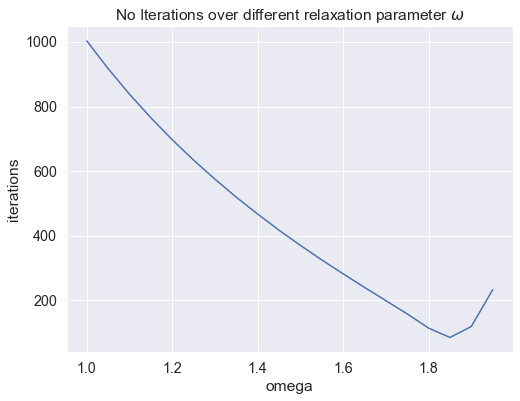

omega optimum between 1.8000000000000007 and 1.9000000000000008 ran over 85.0 iterations


In [78]:
sor_results = pd.DataFrame({
    'omega': omegas
    ,'runtime': runtimes
    ,'error': errors
    ,'iterations': iterations
    
})

fig, axs = plt.subplots(figsize=(8,6))
sns.lineplot(sor_results.omega, sor_results.iterations)
plt.title('No Iterations over different relaxation parameter $\omega$')
plt.show()

opt_index = sor_results.iterations.idxmin()
w_opt_range = sor_results.iloc[opt_index-1: opt_index+2].omega
min_iterations = sor_results.iloc[sor_results.iterations.idxmin()].iterations
print(f'omega optimum between {w_opt_range.min()} and {w_opt_range.max()} ran over {min_iterations} iterations')

From the theorem `3.8` from "Numerical Linear Algebra" (Dougalis, Noutsos, Hatzidimos) we know that
$$\omega_{opt} = \frac{2}{1+\sqrt{1+\beta^2}}$$ where $\beta = \rho(T_{jacobi})$

as long as the table is-two cyclic and $\beta = \rho(T_{jacobi}) < 1$ or in other words the Jacobi method converges. We already know that the Jacobi method converges since `T` is a diagonally dominant matrix, meaning that the sum of non diagonal elements is less than the diagonal element. We also know, from the definition, that `T` is a block tridiagonal matrix which by definition is a two-cyclic matrix. Since all the conditions of the theorem are satisfied and assuming that we know analytically the eigenvalues of $T_{jacobi}$ we have:

In [4]:
from scipy.linalg import eigvals

#calculate the T jacobi table
D = T * np.identity(len(T))
D_inv = np.diag(1/np.diag(D))
L = -np.tril(T, -1)
U = -np.triu(T, 1)
T_jacobi = D_inv @ (L+U)

In [5]:
# find the eigenvalues and keep the one with the maximum absolute value
ev  = eigvals(T_jacobi)
sr = max(abs(ev))

In [6]:
omega_opt = 2 / (1+np.sqrt(1-sr**2))
print (f'optimum omega: {omega_opt}')

optimum omega: 1.8263905415884794


Indeed the optimum $\omega$ falls between the range observed when we tried to approach it experimentally.

## 4. $\omega_{opt}$
We know from the theorem of Kahan that in order for the SOR method to converge we need:
$$|\omega-1|<1$$

Also from our experimental results, we observed that values greater than the optimum $\omega$ converged much faster than values less than optimum $\omega$. As a results, based on our findings, it is better to overestimate $\omega$, always in the range defined by Kahan's theorem, otherwise the system will not converge.